# 正則化

学習済みモデルの評価や過学習という課題、そして正則化という対策について。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(11)


---

## モデルの評価

学習済みモデルをどう評価しようかという話。

基本的にはモデルの予測値が正解とどれだけ近いかを評価する。その評価指標は色々あり、例えば回帰だったら平均二乗誤差とか、それを正規化した決定係数とか、また分類だったら正解率とか。

これらの指標を求めるためにはモデルへの入力と正解のペアが適当な数必要になるが、それらはどこから得ると良いだろう。学習させたデータから適当に持ってくると良いと思うかもしれないが、それではモデルの**汎化性能**を測れない。学習時にモデルが見なかった「未知のデータ」に対してどのようなパフォーマンスを発揮するかが測れない。

そこで、評価指標の算出には学習時に使わなかったデータを用いるようにする。用意したデータの一部は学習に使用せず残しておき、学習後にそのデータを使って評価指標を算出するということ。学習に使用するデータは**訓練データ**、評価に使用するデータは**テストデータ**と呼ぶ。

やってみよう。

In [2]:
# サンプルデータの読み込み
from sklearn.datasets import load_diabetes
X, y = load_diabetes(return_X_y=True)

これを訓練データとテストデータに分ける。

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=11
)
len(X_train), len(X_test)

(353, 89)

ランダムで4:1に分けられた。ここから訓練データ（`X_train, y_train`）を学習させ、テストデータ（`X_test, y_test`）で評価する。評価指標は決定係数とする。1に近いほど良い。

In [4]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test) # 決定係数

0.5771689611166473

これで汎化性能を考慮した評価ができた。


---

## 過学習

*Overfitting*

訓練データでの性能は良いがテストデータでの性能が悪い、という状態。訓練データに過剰に適合してしまっており、汎化性能が低い。

例えば、こんなサンプルがあるとする。

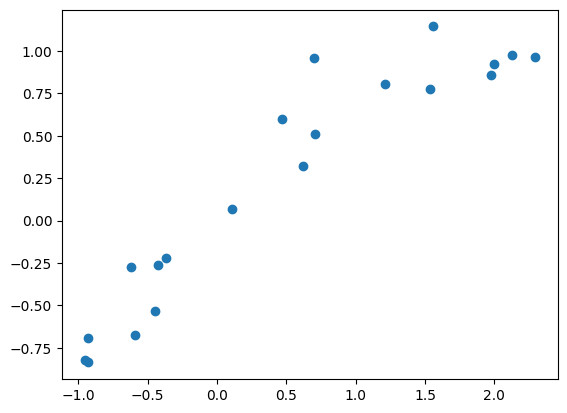

In [5]:
x_range = (-1, 2.5)
def get_samples(n):
    x = np.random.uniform(*x_range, n)
    y = np.sin(x) + 0.2 * np.random.randn(n)
    return x.reshape(-1, 1), y

X, y = get_samples(20)
plt.scatter(X, y);

これを半分に分け、訓練データ、テストデータとする。

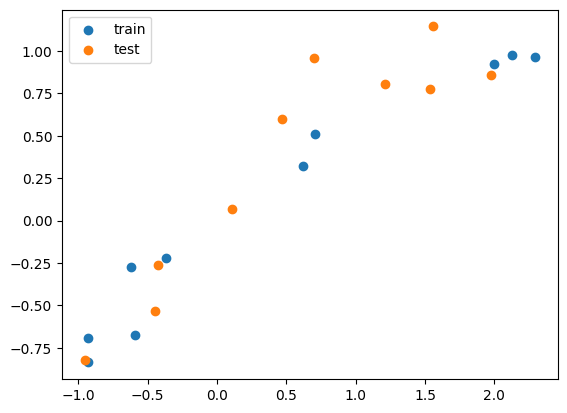

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=11
)
plt.scatter(X_train, y_train, label="train")
plt.scatter(X_test, y_test, label="test")
plt.legend();

この訓練データに10次の多項式を適合させ、評価してみる。

score (train): 1.00
score (test): -104.33


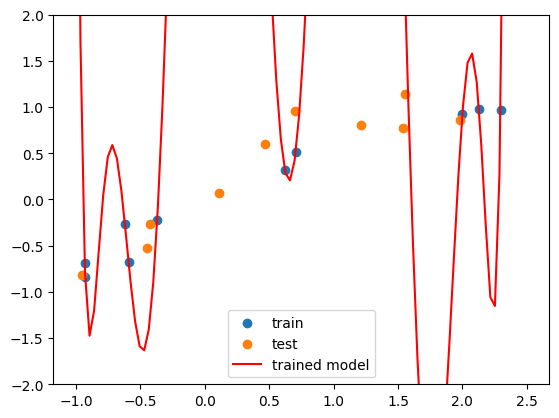

In [7]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

def evaluate(model, X_train, X_test, y_train, y_test):
    score_train = r2_score(y_train, model.predict(X_train))
    score_test = r2_score(y_test, model.predict(X_test))
    print(f"score (train): {score_train:.2f}")
    print(f"score (test): {score_test:.2f}")

    x_axis = np.linspace(*x_range, 100).reshape(-1, 1)
    y_pred = model.predict(x_axis)
    plt.scatter(X_train, y_train, label="train")
    plt.scatter(X_test, y_test, label="test")
    plt.plot(x_axis, y_pred, color="red", label="trained model")
    plt.ylim(-2, 2)
    plt.legend()


poly = PolynomialFeatures(degree=10, include_bias=False)
model = LinearRegression()
pipeline = Pipeline([("poly", poly), ("model", model)])
pipeline.fit(X_train, y_train)
evaluate(pipeline, X_train, X_test, y_train, y_test)

10次のモデルなのでかなり複雑な曲線になった。図からはみ出ているので描画範囲を広げてみる。

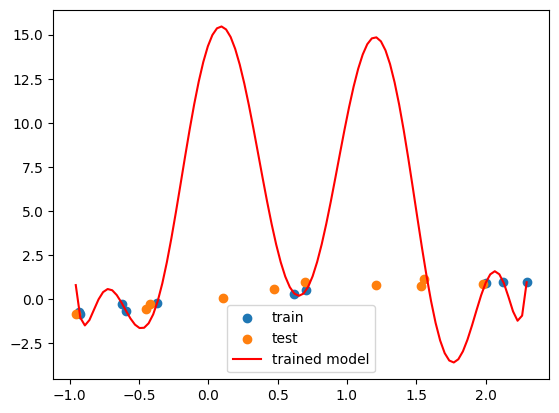

In [8]:
x_axis = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_pred = pipeline.predict(x_axis)
plt.scatter(X_train, y_train, label="train")
plt.scatter(X_test, y_test, label="test")
plt.plot(x_axis, y_pred, color="red", label="trained model")
plt.legend();

このモデルは訓練データには適合しているが、テストデータには全く適合していない。図からも決定係数からも分かるね。これが正に、過学習が起こっている状態となる。訓練データのみに過剰に適合している状態。

では、どうすれば過学習を防げるだろう。色々な手法があるので紹介する。

まず、モデルの複雑さを抑えること。今回で言うと、多項式の次数を下げるなどが有効。表現力が高すぎるモデルは過学習を起こしやすい。

試しに次数を3に下げてみる。

score (train): 0.98
score (test): 0.88


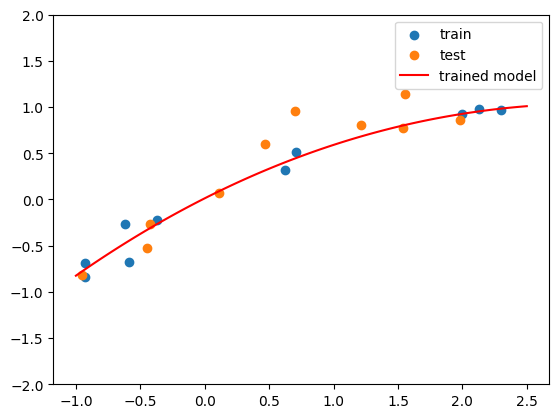

In [9]:
poly = PolynomialFeatures(degree=3, include_bias=False) # 多項式の次数を3に変更
model = LinearRegression()
pipeline = Pipeline([("poly", poly), ("model", model)])
pipeline.fit(X_train, y_train)
evaluate(pipeline, X_train, X_test, y_train, y_test)

決定係数はどちらも高い値となり、図からもモデルが適切に適合していることがわかる。

もう一つの手法は、データを増やすこと。多様なデータを与えることで過学習が抑制される。

score (train): 0.91
score (test): 0.84


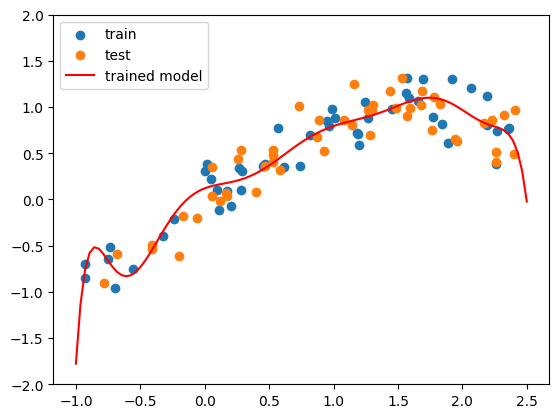

In [10]:
poly = PolynomialFeatures(degree=10, include_bias=False)
model = LinearRegression()
pipeline = Pipeline([("poly", poly), ("model", model)])
X, y = get_samples(100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=11
)
pipeline.fit(X_train, y_train)
evaluate(pipeline, X_train, X_test, y_train, y_test)

データ数を20から100に増やした。これにより、10次のモデルでも過学習が抑制された。

過学習を抑えるためには、モデルの複雑さを抑えることや、データを増やすことが有効であると分かった。なるべく多くのデータを集めるようにし、その数や特徴に応じて適切なモデルを選ぶことが重要である。無駄に複雑なモデルを選ばないようにしよう。

また過学習を抑える手法として正則化というものもある。これについては次章で説明する。


---

## 正則化

*Regularization*

目的関数に正則化項を追加し、モデルの複雑さを抑える手法。過学習を抑制する手法の一つ。

先ほど、モデルが複雑すぎると過学習が起こると学んだ。そこで、モデルの複雑さを表す関数を正則化項として目的関数に追加し、モデルを単純にすることを考える。

$$
J(\theta) = L(\theta) + \alpha R(\theta)
$$

$L(\theta)$は損失関数で、予測精度を表す。ここに正則化項$\alpha R(\theta)$を追加したものを新たな目的関数$J(\theta)$として定義する。

また、$\alpha$は正則化の強さを表す**ハイパーパラメータ**で、正の実数。ハイパーパラメータとは、学習によって最適化されることはなく、人間が設定する必要がある。どの値が適切かはその人の経験や試行錯誤によって判断する。

$R(\theta)$はモデルの複雑さを表す関数であるが、どのような関数を設定すると良いだろうか。

ここで、過学習が起きた場面でパラメータがどうなっているかを考える。

score (train): 1.00
score (test): -6719.68


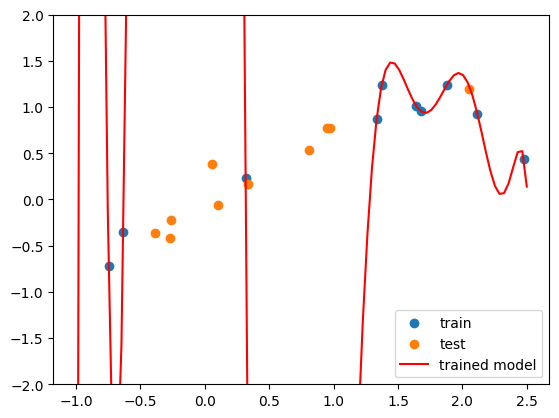

In [11]:
X, y = get_samples(20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=11
)
poly = PolynomialFeatures(degree=10, include_bias=False)
model = LinearRegression()
pipeline = Pipeline([("poly", poly), ("model", model)])
pipeline.fit(X_train, y_train)
evaluate(pipeline, X_train, X_test, y_train, y_test)

これが過学習が起きている状態。このモデルの重みパラメータ（回帰係数）を見てみる。

In [12]:
pipeline["model"].coef_

array([-150.61320408, -350.17330148,  621.41123733,  344.19485934,
       -917.83839954,  229.85865597,  364.51563765, -290.19768738,
         82.19306086,   -8.42582554])

過学習が起きていない場合と比較してみよう。

score (train): 0.91
score (test): 0.80


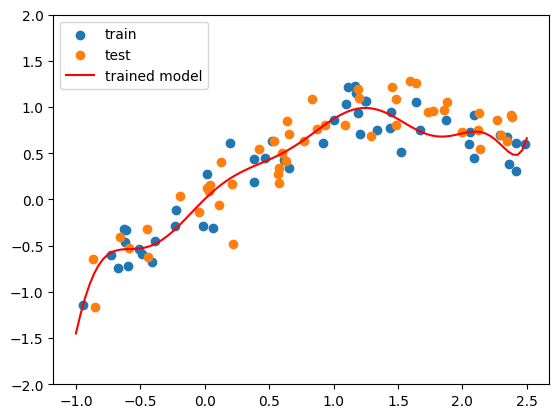

In [13]:
X, y = get_samples(100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=11
)
poly = PolynomialFeatures(degree=10, include_bias=False)
model = LinearRegression()
pipeline = Pipeline([("poly", poly), ("model", model)])
pipeline.fit(X_train, y_train)
evaluate(pipeline, X_train, X_test, y_train, y_test)

In [14]:
pipeline["model"].coef_

array([ 1.35938562, -0.88879616, -2.03053611,  3.78105733,  1.52804216,
       -4.63454227,  1.06468668,  1.33549811, -0.7606869 ,  0.11358709])

過学習が起きているモデルは重みパラメータの絶対値が大きいことが分かる。ということで、$R(\theta)$はパラメータの絶対値の大きさを表す関数として設定すると良さそうだ。


---

## Ridge

正則化項にL2ノルム（パラメータの二乗和）を用いた線形回帰モデル。L2正則化とも呼ばれる。

Ridge回帰では、パラメータの二乗和がモデルの複雑さを表すと仮定する。

$$
\begin{align}
R(\bm\theta) &= \sum_{i=1}^m \theta_i^2 = \|\bm\theta\|_2^2 \\
\bm\theta&\in\mathbb{R}^m
\end{align}
$$

目的関数は以下のようになる。

$$
\begin{align}
J(\bm w)
    &= \| \bm y - \bm X \bm w \|_2^2 + \alpha R(\bm w) \\
    &= \| \bm y - \bm X \bm w \|_2^2 + \alpha \| \bm w \|_2^2 \\
\end{align}
$$

これを解く。

解き方は同じで、微分して0になる点を求めるだけ。

一つ目の項の微分は前章で求めているので、そこに正則化項の微分を足す。

$$
\begin{align}
\frac{\partial J}{\partial \bm w}
	&= -2X^T\bm y + 2X^TX\bm w + \frac{\partial}{\partial \bm w}\alpha\|\bm w\|_2^2 \\
	&= -2X^T\bm y + 2X^TX\bm w + 2\alpha\bm w
\end{align}
$$

これが0になる点を求める。

$$
\begin{align}
-2X^T\bm y + 2X^TX\bm w + 2\alpha\bm w &= 0 \\
X^TX\bm w + \alpha\bm w &= X^T\bm y \\
X^TX\bm w + \alpha I\bm w &= X^T\bm y \\
(X^TX\bm + \alpha I)\bm w &= X^T\bm y \\
\bm w &= (X^TX + \alpha I)^{-1}X^T\bm y
\end{align}
$$

おわり。$\alpha I$が足されただけ。$I$は単位行列。

実装してみる。

In [15]:
class Ridge:
    def __init__(self, alpha=1.):
        self.alpha = alpha
        self.weights = None

    def fit(self, X, y):
        X = np.insert(X, 0, 1, axis=1)
        I = np.identity(X.shape[1], dtype=np.float32)
        I[0, 0] = 0 # バイアス項は無視
        self.weights = np.linalg.inv(X.T @ X + self.alpha*I) @ X.T @ y

    def predict(self, X):
        X = np.insert(X, 0, 1, axis=1)
        return X @ self.weights

バイアスに当たる$w_0$は正則化しない。しても過学習の抑制につながらないため。

$\alpha I$の$w_0$に対応する部分を0にすることで$w_0$については通常の線形回帰と同じ式になるため、正則化をしないことと同じ意味になる。

これを学習させてみる。

score (train): 0.90
score (test): 0.79


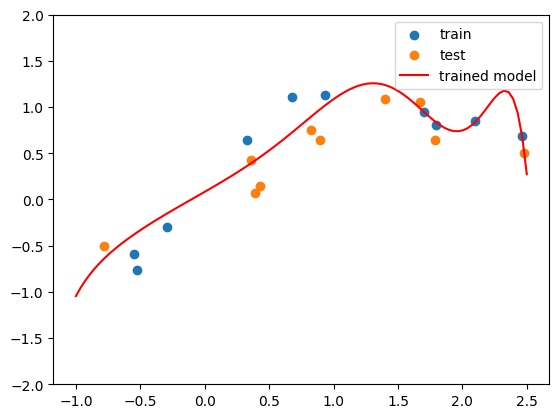

In [16]:
X, y = get_samples(20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=10
)
poly = PolynomialFeatures(degree=10, include_bias=False)
model = Ridge(alpha=1.)
pipeline = Pipeline([("poly", poly), ("model", model)])
pipeline.fit(X_train, y_train)
evaluate(pipeline, X_train, X_test, y_train, y_test)

先ほどは過学習を起こしていた場面（少ないデータ&複雑なモデル）だが、正則化によって過学習が抑制された。

最後にsklearnの結果と一致するかを確かめよう。

In [17]:
model.weights[0], model.weights[1:]

(0.0828840461246389,
 array([ 0.80198207,  0.06794093,  0.24442612,  0.00978563,  0.01480635,
        -0.08262937, -0.07822485, -0.0371512 ,  0.08282683, -0.02089181]))

In [18]:
from sklearn.linear_model import Ridge
correct_model = Ridge(alpha=1.)
pipeline = Pipeline([("poly", poly), ("model", correct_model)])
pipeline.fit(X_train, y_train)
pipeline["model"].intercept_, pipeline["model"].coef_

(0.08288404567026769,
 array([ 0.80198207,  0.06794093,  0.24442612,  0.00978563,  0.01480635,
        -0.08262937, -0.07822485, -0.0371512 ,  0.08282683, -0.02089181]))

同じになったね。（バイアスがほんの少し違うのは誤差かな。実装方法が若干違うのだと思う。）